In [2]:
import pandas as pd 
from gwpy.timeseries import TimeSeries
#Setup
pem = 'L1:PEM-CS_MAINSMON_EBAY_1_DQ' #pem channel
strain_channel = 'L1:DCS-CALIB_STRAIN_C01_AR' #strain channel

#Get a segment of strain data 
df = pd.read_csv('../../data/L1-O3a-segments.csv',header=None)
i = 0
t0 = df.iloc[i][0]
t1 = t0 + (10*60)# 10 mins later
hoft   = TimeSeries.get(strain_channel,start=t0, end=t1,host='losc-nds.ligo.org')


In [6]:
#Load the pem data
acc = TimeSeries.read(f'../../data/pem_channels/{pem}.txt')

In [7]:
#Downsample the strain data to match the pem data
hoft_downsampled = hoft.resample(acc.sample_rate)


/Users/t1/miniconda3/envs/LIGO_ANC/lib/python3.9/site-packages/gwpy/signal/spectral/_scipy.py:223: UserWarning: Sampling frequencies are unequal. Higher frequency series will be downsampled before coherence is calculated
  warnings.warn("Sampling frequencies are unequal. Higher "


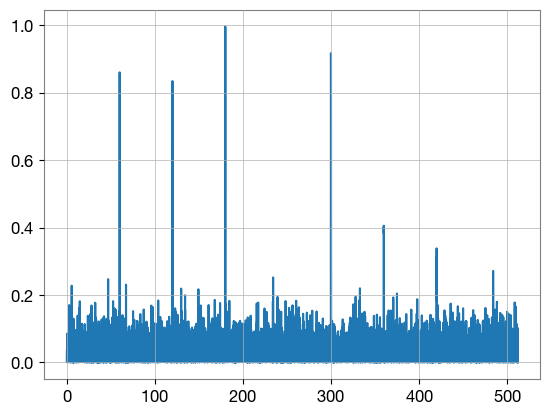

In [8]:
#Plot the coherence like we usually do
import numpy as np 
import matplotlib.pyplot as plt 
coh = hoft.coherence(acc, fftlength=2, overlap=1)
coherence_frequencies = np.array(coh.frequencies)
coherence_values = np.array(coh)
plt.plot(coherence_frequencies,coherence_values)
plt.show()

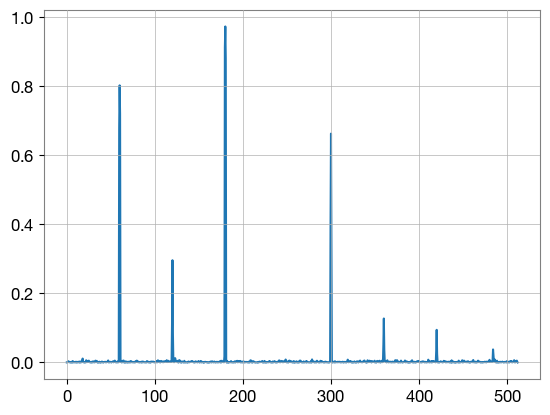

In [9]:
#...and the downsampled version
import numpy as np 
import matplotlib.pyplot as plt 
coh = hoft_downsampled.coherence(acc, fftlength=2, overlap=1)
coherence_frequencies = np.array(coh.frequencies)
coherence_values = np.array(coh)
plt.plot(coherence_frequencies,coherence_values)
plt.show()

### Naive manual coherence via PSD

In [10]:
from scipy import signal
f,cross_psd = signal.csd(np.array(hoft_downsampled),np.array(acc),fs=acc.sample_rate.value)
f,Pxx = signal.csd(np.array(hoft_downsampled),np.array(hoft_downsampled),fs=acc.sample_rate.value)
f,Pyy = signal.csd(np.array(acc),np.array(acc),fs=acc.sample_rate.value)

In [42]:
manual_coherence = np.abs(cross_psd)**2 / (Pxx*Pyy)

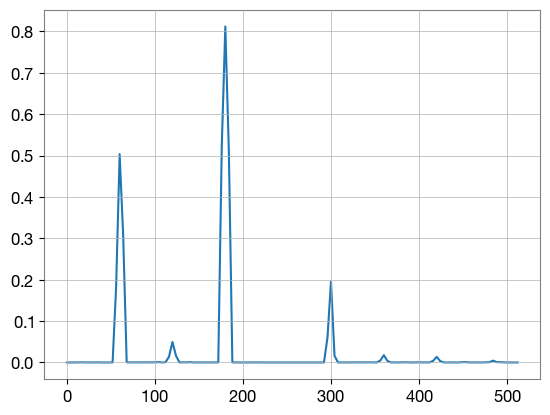

In [45]:
plt.plot(f,np.abs(manual_coherence))
plt.show()

### Coherence via cross-correlation 

In [78]:
cross_correlation= signal.correlate(np.array(hoft_downsampled),np.array(acc),mode='same') # mode can be ``full`, `valid` or `same`. Looks like GWpy uses `same`
auto_correlation_xx= signal.correlate(np.array(hoft_downsampled),np.array(hoft_downsampled),mode='same') # mode can be ``full`, `valid` or `same`. Looks like GWpy uses `same`
auto_correlation_yy= signal.correlate(np.array(acc),np.array(acc),mode='same') # mode can be ``full`, `valid` or `same`. Looks like GWpy uses `same`


In [79]:
from scipy.fft import fft
cross_psd = fft(cross_correlation)
Pxx = fft(auto_correlation_xx)
Pyy = fft(auto_correlation_yy)

In [80]:
import scipy
freqs = scipy.fftpack.fftfreq(np.array(hoft_downsampled).size, 1/1024)

In [84]:
manual_coherence = np.abs(cross_psd)**2 / (Pxx*Pyy)

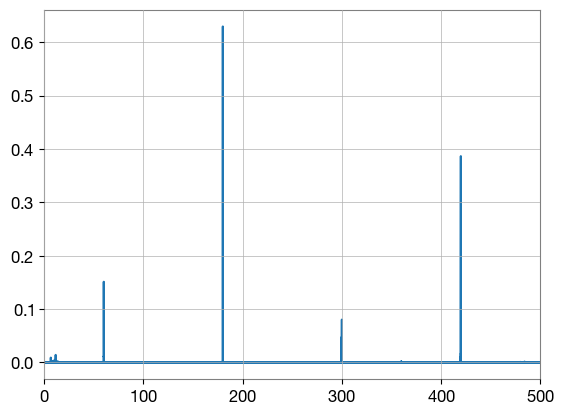

In [87]:
plt.plot(freqs,np.abs(manual_coherence))
plt.xlim(0,500)
plt.show()

## How about just the cross-correlation, not the coherence?

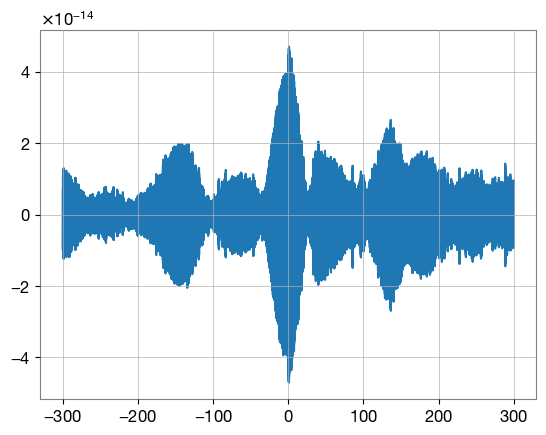

In [89]:
cross_correlation= signal.correlate(np.array(hoft_downsampled),np.array(acc),mode='same') # mode can be ``full`, `valid` or `same`. Looks like GWpy uses `same`

dt = 1.0 / acc.sample_rate.value
lengths = len(np.array(hoft_downsampled))
lags = signal.correlation_lags(lengths, lengths,mode='same') * dt #time sampling is constant

plt.plot(lags,cross_correlation)
plt.show()


# What if we filter first?

In [12]:
acc 

<TimeSeries([  126.42769623,  -740.5881958 , -1650.49328613, ...,
               -17.08509254,   849.35693359,  1737.00866699]
            unit=Unit(dimensionless),
            t0=<Quantity 1.23816602e+09 s>,
            dt=<Quantity 0.00097656 s>,
            name=None,
            channel=None)>

In [13]:
hoft_downsampled

<TimeSeries([-1.40807601e-20, -3.64214050e-20, -3.21229296e-20,
             ...,  6.97338806e-19,  6.84707234e-19,
              6.69630486e-19]
            unit=Unit("strain"),
            t0=<Quantity 1.23816602e+09 s>,
            dt=<Quantity 0.00097656 s>,
            name='L1:DCS-CALIB_STRAIN_C01_AR',
            channel=<Channel("L1:DCS-CALIB_STRAIN_C01_AR" [reduced], 16384.0 Hz) at 0x7f852002c190>)>

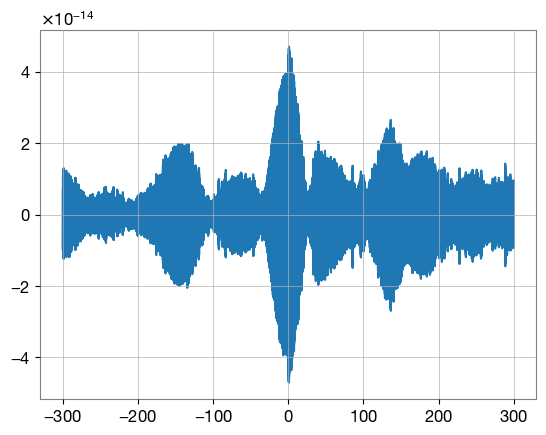

In [11]:
cross_correlation= signal.correlate(np.array(hoft_downsampled),np.array(acc),mode='same') # mode can be ``full`, `valid` or `same`. Looks like GWpy uses `same`

dt = 1.0 / acc.sample_rate.value
lengths = len(np.array(hoft_downsampled))
lags = signal.correlation_lags(lengths, lengths,mode='same') * dt #time sampling is constant

plt.plot(lags,cross_correlation)
plt.show()
